<a href="https://colab.research.google.com/github/absolution-end/Text_in_tensorflow/blob/main/Subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

subword tokinazation with imdb dataset

lab setup

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp

Load imdb reviews

In [23]:
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir='./data', download=True)

In [24]:
train_reviews = imdb['train'].map(lambda reviews, lables: reviews)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, lable: lable)

In [25]:
list(train_reviews.take(2))

[<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howev

Subword tokinization

In [26]:
# Parameter for tokinization and padding
vocab_size = 10000
max_len = 120
padding_type = 'pre'
truncate = 'post'

In [27]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
vectorize_layer.adapt(train_reviews)

In [75]:
def padding_function(sequences):
  '''generates padded sequences from a tf.data.Dataset'''
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())
  sequences = sequences.get_single_element()
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  maxlen=max_len,
                                                  padding=padding_type,
                                                  truncating=truncate)
  padding = tf.data.Dataset.from_tensor_slices(padded_sequences)
  return padding

In [58]:
# To apply vectorization and padding layer on the text inputs
train_sequences = train_reviews.map(lambda x: vectorize_layer(x)).apply(padding_funcation)

In [60]:
# get the vocabulary
imdb_vocab_fullword = vectorize_layer.get_vocabulary()

# get sample integer sequence
sample_sequence = train_sequences.take(1).get_single_element()

# to look each token in the vocabulary
decode_text = [imdb_vocab_fullword[war] for war in sample_sequence]

# combine the word
decoded_text = " ".join(decode_text)
print(decoded_text)

    this was an absolutely terrible movie dont be [UNK] in by christopher walken or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the [UNK] rebels were making their cases for [UNK] maria [UNK] [UNK] appeared phony and her [UNK] affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher [UNK] good name i could barely sit through it


we have encountered with the OOVs (out of vocabulary) and now if we train on 88k we might end with the desired output but here, right now its 10k

we will compute the subword vocabulary using the compute_word_piece_vocabulary()

In [61]:
# Compute a subword vocabulary to a file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_reviews,
    vocabulary_size=80000,
    reserved_tokens=["[PAD]","[UNK]"],
    vocabulary_output_file="./data/imdb_vocab.txt",
)

we will initialize a WordPieceTokenizer using the vocabulary. This will behave similar to the TextVectorization layer you've been using so far, but it is able to generate subword sequences.

In [62]:
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary="./data/imdb_vocab.txt",
)

In [65]:
# print subwords
print(subword_tokenizer.get_vocabulary())
subword_tokenizer.vocabulary_size()

['[PAD]', '[UNK]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '', '¡', '¢', '£', '¤', '¦', '§', '¨', '«', '®', '°', '³', '´', '·', 'º', '»', '½', '¾', '¿', 'À', 'Á', 'Ã', 'Ä', 'Å', 'È', 'É', 'Ê', 'Õ', 'Ø', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'ō', '–', '‘', '’', '“', '”', '…', '₤', '\uf0b7', 'the', 'and', 'of', 'to', 'is', 'br', 'in', 'it', 'that', 'this', 'was', 'The', 'as', 'movie', 'with', 'for', 'film', 'but', 'on', 'you', 'are', 'not', 'his', 'have',

26357

In [66]:
# Get a sample review
sample_review = train_reviews.take(1).get_single_element()

# Encode the first plaintext sentence using the subword text encoder
tokenized_string = subword_tokenizer.tokenize(sample_review)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode the sequence
original_string = subword_tokenizer.detokenize(tokenized_string)

# Print the result
print('The original string: {}'.format(original_string))

Tokenized string is [  208   174   194   628   593   177    15   634     8    85   188 13013
   170   191  1553  3733   202   651 12847    15  1713   184   248   316
    13   181   173   378   510   188   228   427   376   170   684    15
   560   228   248   275   256   185  6556   173   177     8    84   829
   953    15   208   177   168   194   600 10822  1264  2809   599    15
   175   251  1456   300   231   318   220   164  8137   632  9164   231
   401   228  3344   179  3832   207    15  3117 23552  8763  3252 23484
  1688  5677    13   165   201  4480    14   289  1841   178  3733   174
   341   181    66  1456  1088  9338   170    66   177   172   174  4760
   166   262   312  1424    15    42   412   856   172   216   184   259
   198   173    13  8453   454     8    84   198  1553  3733     8    84
   209   590    15    42   256  1394  1057   308   171    15]
The original string: This was an absolutely terrible movie . Don ' t be lured in by Christopher Walken or Michael I

In [67]:
# Define sample sentence
sample_string = 'TensorFlow, from basics to mastery'

# Encode using the plain text tokenizer
tokenized_string = vectorize_layer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [ 1 36  1  6  1]
The original string: [UNK] from [UNK] to [UNK]


In [70]:
# Encode using the subword text encoder
tokenized_string = subword_tokenizer.tokenize(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

# Decode and print the results
original_string = subword_tokenizer.detokenize(tokenized_string)
print('The original string: {}'.format(original_string))

Tokenized string is [ 6265 24945  4450  8907    13   197 12604   167 13722]
The original string: TensorFlow , from basics to mastery


In [72]:
# Show token to subword mapping:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, subword_tokenizer.detokenize([ts])))

6265 ----> Ten
24945 ----> ##sor
4450 ----> ##F
8907 ----> ##low
13 ----> ,
197 ----> from
12604 ----> basics
167 ----> to
13722 ----> mastery


Train model

In [76]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_function)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_function)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [78]:
# Define dimensionality of the embedding
embedding = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(max_len,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), embedding),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 64)             │       1,686,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,687,245 (6.44 MB)

 Trainable params: 1,687,245 (6.44 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
epoch = 10
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(train_dataset_final , epochs=epoch, validation_data= test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.6777 - loss: 0.6210 - val_accuracy: 0.7830 - val_loss: 0.4519
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.8570 - loss: 0.3372 - val_accuracy: 0.7829 - val_loss: 0.4587
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9072 - loss: 0.2412 - val_accuracy: 0.7753 - val_loss: 0.5074
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9359 - loss: 0.1793 - val_accuracy: 0.7750 - val_loss: 0.5567
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9557 - loss: 0.1318 - val_accuracy: 0.7724 - val_loss: 0.6219
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.9729 - loss: 0.0949 - val_accuracy: 0.7690 - val_loss: 0.7004
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9829 - loss: 0.0673 - val_accuracy: 0.7734 - val_loss: 0.7659
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9895 - loss: 0.0467 - 

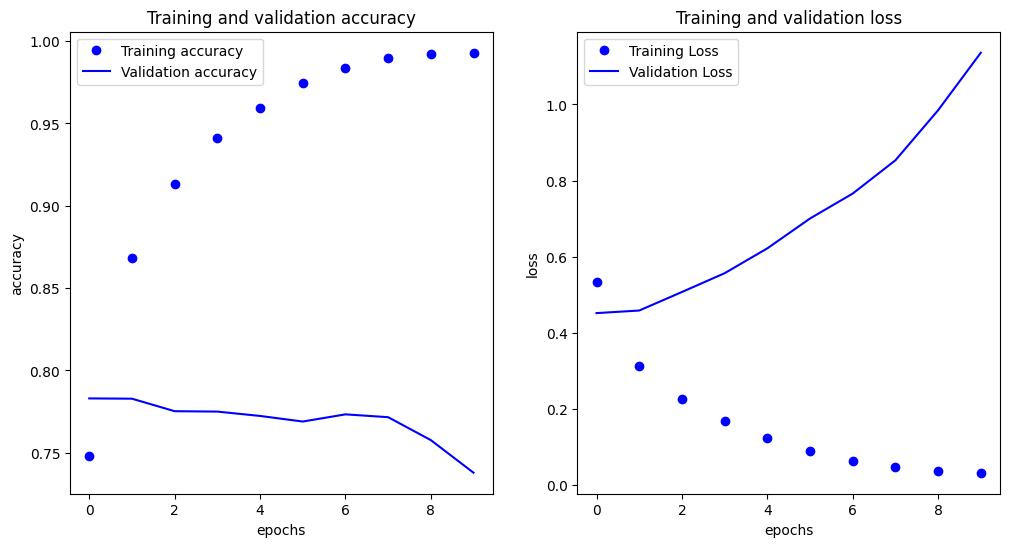

In [84]:
def graph(history):
  acc = history.history["accuracy"]
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

graph(history)